# PrediCare - Prediction of Breast Cancer

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
# Importing libaries
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt




### Data processing:
- fetching data
- train-test split


In [28]:
def get_image_data(data_path):
  ''' function for fetching the directory of the image data from corresonding folders
      and store them and the corresponding folder name in lists '''
  # Initializing empty lists to store images files and folder name as the target
  image_path = []
  target_value = []

  # Looping through each folder (malignant, benign, normal)
  for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    # Checking if it is a directory and not a file
    if os.path.isdir(folder_path):
      for file_name in os.listdir(folder_path):
        # Checking if file is an image not containing 'mask' in name
        if file_name.endswith('.png') and 'mask' not in file_name:
          file_path = os.path.join(folder_path, file_name)
          image_path.append(file_path)
          target_value.append(folder)
  return image_path, target_value

def split_data(dataframe):
  ''' function splits the dataframe into train and test data set '''
  train_data, test_data = train_test_split(dataframe, test_size = 0.2, random_state=42, stratify=dataframe['target'])
  return train_data, test_data


In [29]:
# Creating two lists which stores the directory of the images and the corresponding target (malignant, benign, normal)
data_path = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT'
image_path, target_value = get_image_data(data_path)

In [30]:
# Creating dataframe from the generated lists
df = pd.DataFrame({'image_path': image_path, 'target': target_value})

# Split dataframe into train and test data set
train_data, test_data = split_data(df)

In [31]:
# Create directories and folder for train and test data
# the new train_data and test_data folder will be in same directory as the original benign, malignant and normal folders
train_data_dir = os.path.join(data_path, 'train_data')
test_data_dir = os.path.join(data_path, 'test_data')
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

In [32]:
# Copy files to the new directories for train and test data
for index, row in train_data.iterrows():
    src_path = row['image_path']
    dst_path = os.path.join(train_data_dir, os.path.basename(src_path))
    shutil.copy(src_path, dst_path)

for index, row in test_data.iterrows():
    src_path = row['image_path']
    dst_path = os.path.join(test_data_dir, os.path.basename(src_path))
    shutil.copy(src_path, dst_path)

In [19]:
print(train_data.shape)
print(test_data.shape)
print(train_data_dir)


(624, 2)
(156, 2)
/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/train_data


In [33]:
# Creating subfolders according malignant, benign and normal for train_data and test_data folder

train_data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/train_data'
test_data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/test_data'

classes = ['malignant', 'benign', 'normal']
for directory in [train_data_dir, test_data_dir]:
    for name in classes:
        class_dir = os.path.join(directory, name)
        os.makedirs(class_dir, exist_ok=True)

In [35]:
# Moving the corresponding images into the subfolders
def move_files_to_class(src_dir):
  ''' function moves the image files according the filename in the corresponding subfolder '''
  image_files = [filename for filename in os.listdir(src_dir) if filename.endswith('.png')]
  classes = ['malignant', 'benign', 'normal']
  for image_file in image_files:
    for class_name in classes:
      if class_name in image_file:
        src_path = os.path.join(src_dir, image_file)
        dst_path = os.path.join(src_dir, class_name, image_file)
        shutil.move(src_path, dst_path)


In [36]:
move_files_to_class(test_data_dir)
move_files_to_class(train_data_dir)

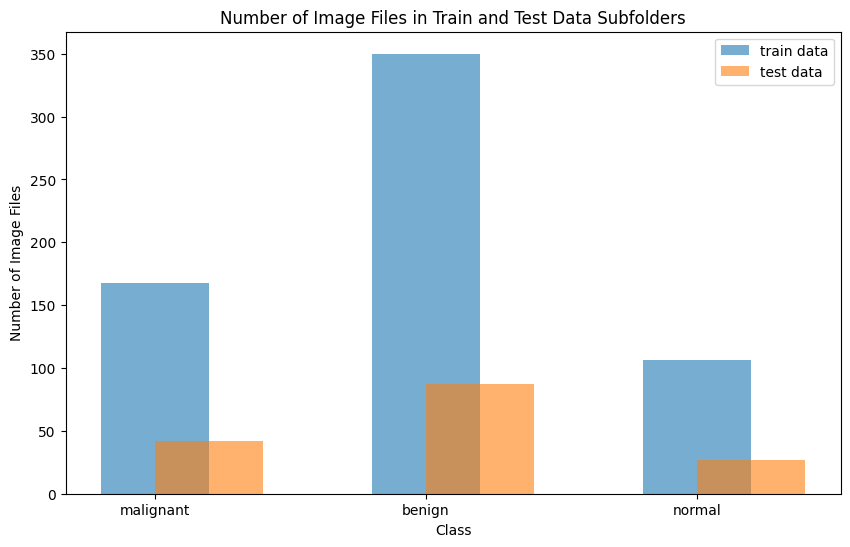

In [43]:
# Visualize the number of images in each subfolder for test_data and train_data
train_data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/train_data'
test_data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/test_data'

# List of subfolders
classes = ['malignant', 'benign', 'normal']

# Initialize lists to store the counts for train and test data
train_counts = []
test_counts = []

# Count the number of files in each subfolder for train_data and test_data
for class_name in classes:
    train_count = len(os.listdir(os.path.join(train_data_dir, class_name)))
    test_count = len(os.listdir(os.path.join(test_data_dir, class_name)))

    train_counts.append(train_count)
    test_counts.append(test_count)

# Create a bar chart to visualize the counts
plt.figure(figsize=(10, 6))
plt.bar(classes, train_counts, width=0.4, label='train data', align='center', alpha=0.6)
plt.bar(classes, test_counts, width=0.4, label='test data', align='edge', alpha=0.6)
plt.xlabel('Class')
plt.ylabel('Number of Image Files')
plt.title('Number of Image Files in Train and Test Data Subfolders')
plt.legend()
plt.show()

### Baseline model
- ANN

In [38]:
train_data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/train_data'
test_data_dir = '/content/drive/MyDrive/SpicedAcademy/PrediCare_BreastCancerPrediction/data/Dataset_BUSI_with_GT/test_data'

image_size = (500, 500)
batch_size = 32

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    #rotation_range=20,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #horizontal_flip=True
)

# Data preprocessing for testing data
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Create a simple CNN model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Assuming 3 classes: malignant, benign, normal
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs
)




Found 624 images belonging to 3 classes.
Found 156 images belonging to 3 classes.
Epoch 1/10
20/20 [==============================] - 356s 17s/step - loss: 10.5403 - accuracy: 0.4856 - val_loss: 1.0044 - val_accuracy: 0.5577
Epoch 2/10
20/20 [==============================] - 359s 18s/step - loss: 0.8796 - accuracy: 0.6074 - val_loss: 0.8463 - val_accuracy: 0.6538
Epoch 3/10
20/20 [==============================] - 315s 16s/step - loss: 0.5832 - accuracy: 0.7628 - val_loss: 0.7586 - val_accuracy: 0.6795
Epoch 4/10
20/20 [==============================] - 337s 17s/step - loss: 0.3475 - accuracy: 0.8686 - val_loss: 0.7545 - val_accuracy: 0.7115
Epoch 5/10
20/20 [==============================] - 331s 17s/step - loss: 0.1255 - accuracy: 0.9663 - val_loss: 1.1168 - val_accuracy: 0.7436
Epoch 6/10
20/20 [==============================] - 319s 16s/step - loss: 0.0649 - accuracy: 0.9920 - val_loss: 0.9053 - val_accuracy: 0.7372
Epoch 7/10
20/20 [==============================] - 328s 16s/step

In [41]:
# Save the model
model.save('baseline_model_cnn.keras')

5/5 [==============================] - 28s 6s/step


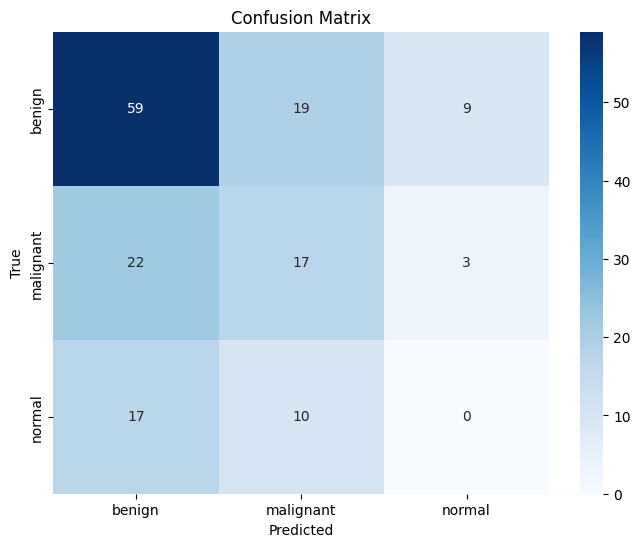

              precision    recall  f1-score   support

      benign       0.60      0.68      0.64        87
   malignant       0.37      0.40      0.39        42
      normal       0.00      0.00      0.00        27

    accuracy                           0.49       156
   macro avg       0.32      0.36      0.34       156
weighted avg       0.44      0.49      0.46       156



In [39]:
# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Create a confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_names = list(test_generator.class_indices.keys())
print(classification_report(true_classes, predicted_classes, target_names=class_names))